In [1]:
import tensorflow as tf
import numpy as np
import pylab as plt
import pandas as pd

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set compatibility mode
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Set pandas display option
pd.options.display.float_format = "{:,.4f}".format 

# RTX ON
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Scale data
def scale(X):
    return (X-np.mean(X,axis=0)) / np.std(X,axis=0)

In [4]:
NUM_FEATURES = 5

hidden_neurons = 50
learning_rate = 10**-3
beta = 10**-3
batch_size = 8
prob = 0.8

epochs = 36511
seed = 42
np.random.seed(seed)

In [5]:
# Read data
data_input = np.genfromtxt('admission_predict.csv', delimiter= ',')

# Excluding GRE Score and CGPA after performing RFE previously
data_X = data_input[1:,[2,3,4,5,7]] 
data_Y = data_input[1:,-1] 

# Scale X inputs
dataX = scale(data_X)
dataY = data_Y.reshape(data_Y.shape[0],1)

# Define the size of training set and data set
dataset_size = len(dataX)
train_size = int(0.7 * dataset_size)
test_size = dataset_size - train_size

# Shuffle the data before splitting to training and testing set
idx = np.arange(dataset_size)
np.random.shuffle(idx)
dataX = dataX[idx]
dataY = dataY[idx]

# Split the training and testing set
trainX = dataX[:train_size]
trainY = dataY[:train_size]

testX = dataX[train_size:]
testY = dataY[train_size:]

In [6]:
# Create the model
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
y_ = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)

# Build the graph for the neural network

# Hidden layer with relu activation
w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, hidden_neurons], stddev=1.0 / np.sqrt(NUM_FEATURES), dtype=tf.float32), name='weights')
b1 = tf.Variable(tf.zeros([hidden_neurons]), dtype=tf.float32, name='biases')
h1 = tf.nn.relu(tf.matmul(x, w1) + b1)
h1_dropout = tf.nn.dropout(h1, keep_prob) 

# Linear output layer
w2 = tf.Variable(tf.truncated_normal([hidden_neurons, 1], stddev=1.0 / np.sqrt(hidden_neurons), dtype=tf.float32), name='weights')
b2 = tf.Variable(tf.zeros([1]),dtype=tf.float32, name='biases')
y = tf.matmul(h1_dropout, w2) + b2 

# Regularization
regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) 

# Regularized loss
loss = tf.reduce_mean(tf.square(y_ - y) + beta*regularization)

# Define the optimiser
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

# Create a variable to track the global step
global_step = tf.Variable(0, name='global_step', trainable=False)

# Use the optimizer to apply the gradients that minimize the loss
# (and also increment the global step counter) as a single training step.
train_op = optimizer.minimize(loss, global_step=global_step)


**Evaluating the performance of the 3-layer neural network without dropout:**


We first try the to evaluate the performance of the 3 layers neural network without dropout.

* This can be done by setting the *keep_prob* during training to be **1.0**.

* The *keep_prob* during testing will always be **1.0** irregardless of whether the network is with or without dropout.

In [7]:
N = train_size
idx_train = np.arange(N)

# Run the session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    test_error_nodropout =[]
  
    for i in range(epochs):
        # Shuffle the training data
        np.random.shuffle(idx_train) 
        trainX = trainX[idx_train]
        trainY = trainY[idx_train]
    
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end], keep_prob:1.0})
            
        test_error_nodropout.append(loss.eval(feed_dict={x: testX, y_: testY, keep_prob: 1.0}))

        if i == 0 or (i+1)%5000 == 0:
            print('[iteration {}]'.format(i+1))    
            print('test error: {}'.format(test_error_nodropout[i]))
            print()

[iteration 1]
test error: 0.44386354088783264

[iteration 5000]
test error: 0.020471680909395218

[iteration 10000]
test error: 0.016425615176558495

[iteration 15000]
test error: 0.013633178547024727

[iteration 20000]
test error: 0.011790136806666851

[iteration 25000]
test error: 0.010476426221430302

[iteration 30000]
test error: 0.009532850235700607

[iteration 35000]
test error: 0.008862641640007496



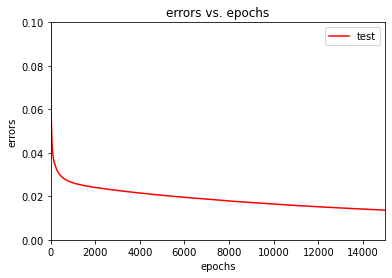

In [8]:
# Plot learning curves
plt.figure()
plt.title('errors vs. epochs')
plt.plot(range(epochs), test_error_nodropout,'r',label='test')
plt.xlabel('epochs')
plt.ylabel('errors')
plt.xlim(0,15000)
plt.ylim(0,0.1)
plt.legend(loc='best')


plt.show()


**Evaluating the performance of the 3-layer neural network with dropout:**


To evaluate the performance of the 3 layers neural network with dropout:

* Simply change *keep_prob* during training to be **prob**.

* The *keep_prob* during testing will always be **1.0** irregardless of whether the network is with or without dropout.

In [9]:
N = train_size
idx_train = np.arange(N)

# Run the session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    test_error_dropout =[]

    for i in range(epochs):
        # Shuffle the training data
        np.random.shuffle(idx_train) 
        trainX = trainX[idx_train]
        trainY = trainY[idx_train]
    
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end], keep_prob:prob})
    
        test_error_dropout.append(loss.eval(feed_dict={x: testX, y_: testY, keep_prob: 1.0}))

        if i == 0 or (i+1)%5000 == 0:
            print('[iteration {}]'.format(i+1))    
            print('test error: {}'.format(test_error_dropout[i]))
            print()

[iteration 1]
test error: 0.4673745334148407

[iteration 5000]
test error: 0.019885556772351265

[iteration 10000]
test error: 0.01571677252650261

[iteration 15000]
test error: 0.012761224992573261

[iteration 20000]
test error: 0.010652778670191765

[iteration 25000]
test error: 0.00915524736046791

[iteration 30000]
test error: 0.008120888844132423

[iteration 35000]
test error: 0.007391864433884621



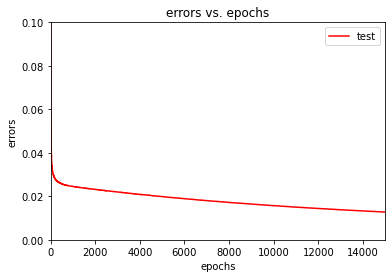

In [10]:
# Plot learning curves
plt.figure()
plt.title('errors vs. epochs')
plt.plot(range(epochs), test_error_dropout,'r',label='test')
plt.xlabel('epochs')
plt.ylabel('errors')
plt.xlim(0,15000)
plt.ylim(0,0.1)
plt.legend(loc='best')

plt.show()

In [11]:
test_error_no_dO = np.array(test_error_nodropout)
np.save('3 layers without dropout',test_error_no_dO)

test_error_w_dO = np.array(test_error_dropout)
np.save('3 layers with dropout',test_error_w_dO)